In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [5]:
binning_method='healpix'
nside=8
bin_space='radec'
specific_years=[2014]
# specific_months=[12],
# specific_days=[15, 16, 17],
include_default_features=True
include_bin_features=False
do_z_score_norm=True
do_cyclical_norm=False

In [6]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    # specific_months=[12],
    # specific_days=[15, 16, 17],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

## Check that normalizations are working

In [7]:
for i, feat_name in enumerate(dataset.state_feature_names):
    print(feat_name, (dataset._df[feat_name].to_numpy() == dataset.next_states[:, i]).all())


ra tensor(False)
dec tensor(False)
az tensor(False)
el tensor(False)
airmass tensor(False)
ha tensor(False)
sun_ra tensor(False)
sun_dec tensor(False)
sun_az tensor(False)
sun_el tensor(False)
moon_ra tensor(False)
moon_dec tensor(False)
moon_az tensor(False)
moon_el tensor(False)
time_fraction_since_start tensor(False)


In [8]:
dataset.cyclical_feature_names

[]

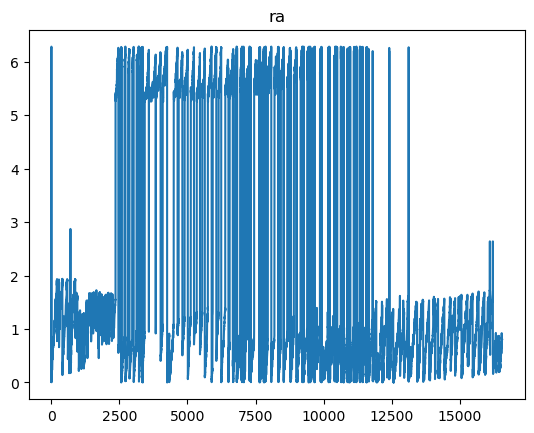

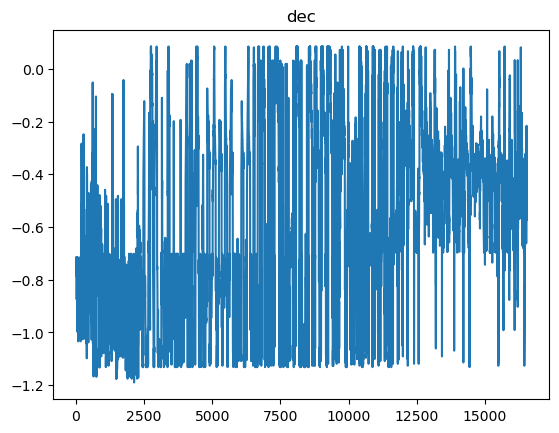

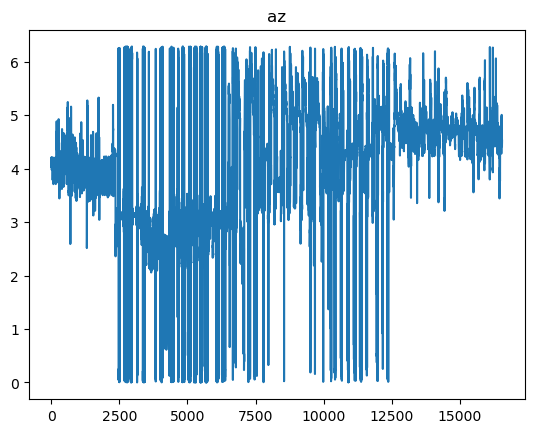

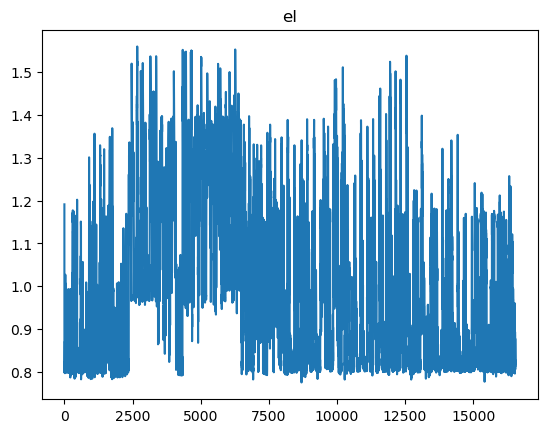

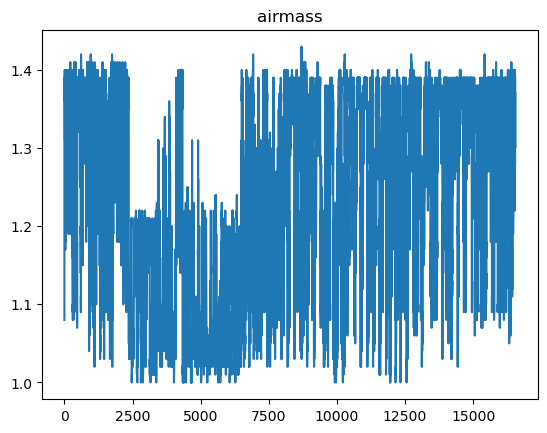

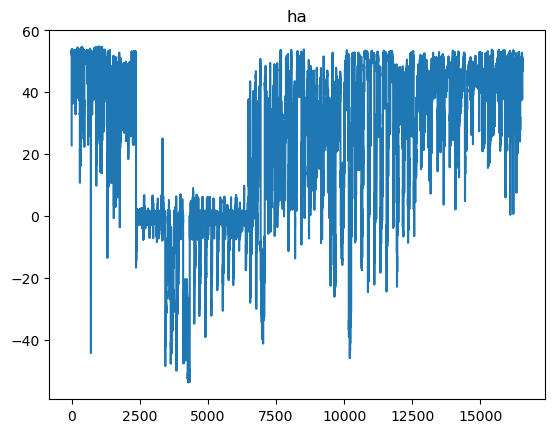

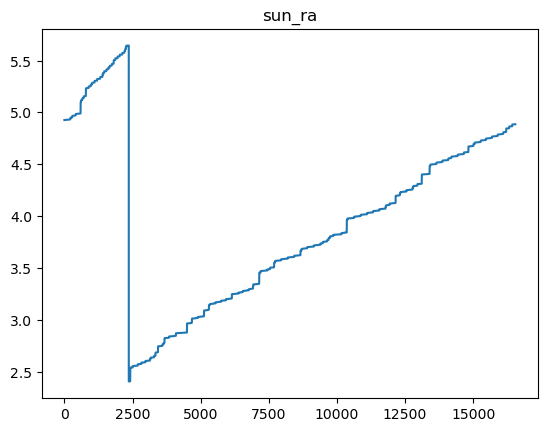

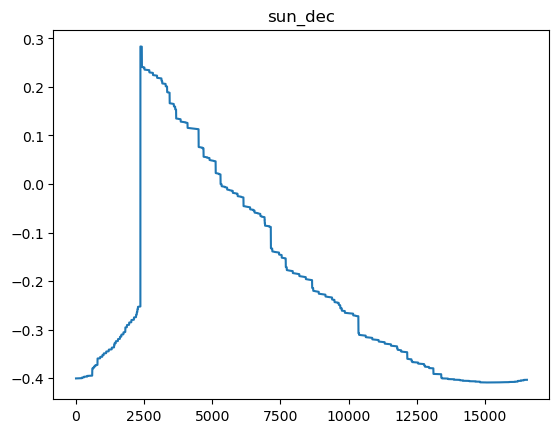

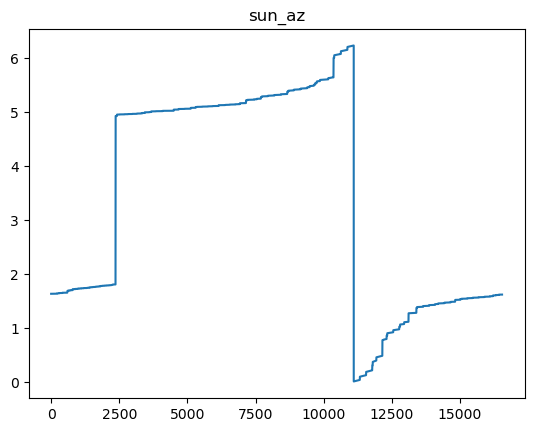

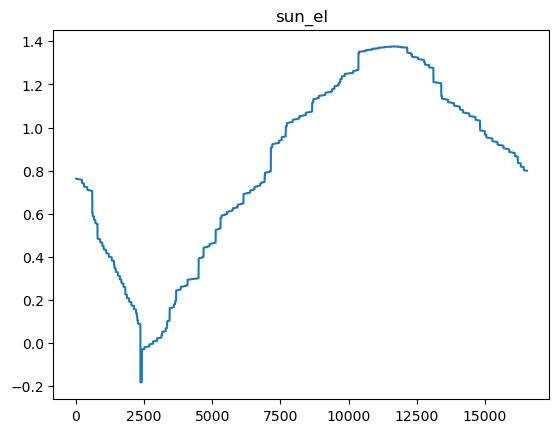

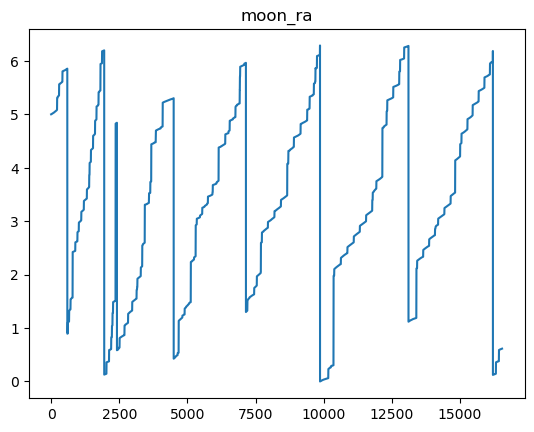

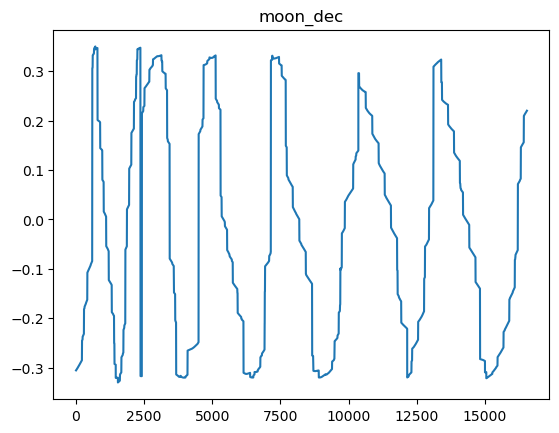

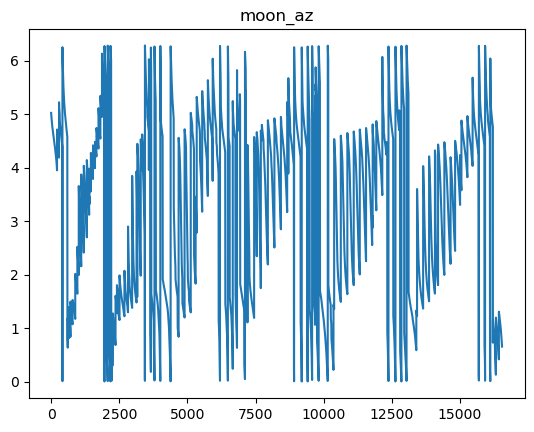

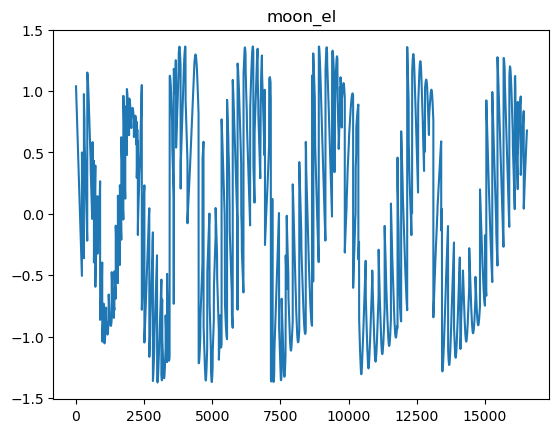

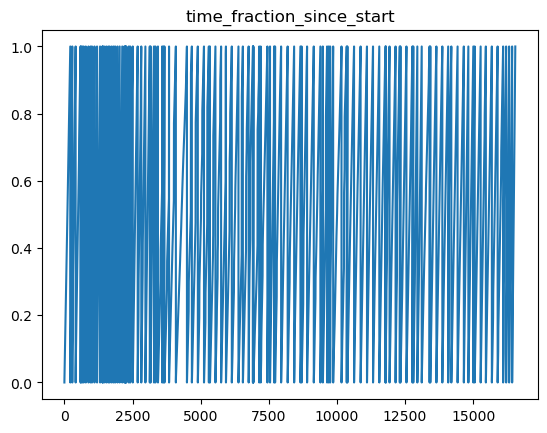

In [8]:
for i, feat_name in enumerate(dataset.state_feature_names):
    plt.plot(dataset._df[feat_name].to_numpy())
    plt.title(feat_name)
    plt.show();

# Visualize dataset in az, el and ra, dec

In [9]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

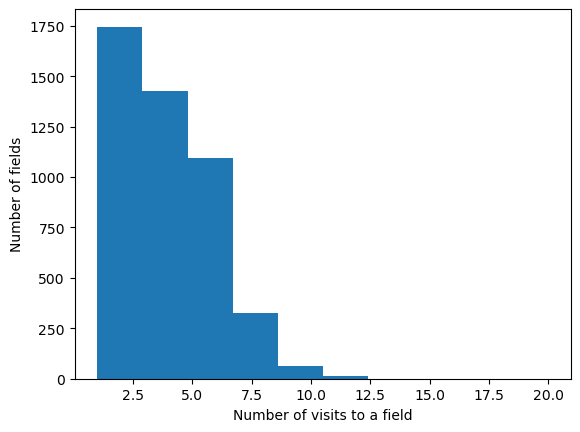

In [10]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

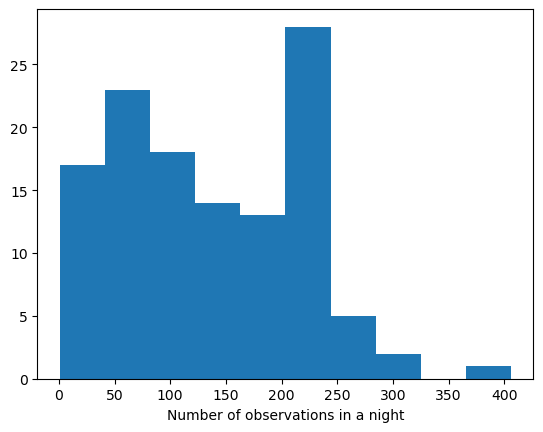

In [11]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

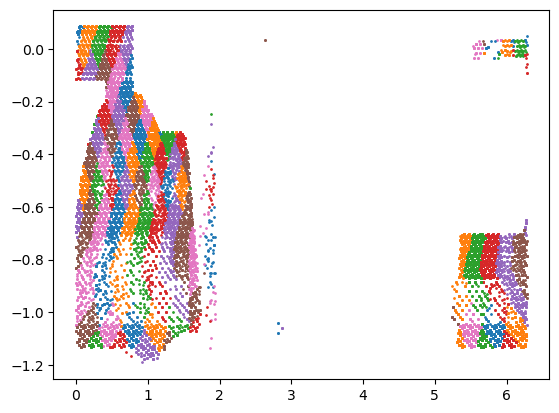

In [12]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [9]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [10]:
dataset.do_z_score_norm

True

In [11]:
dataset.do_cyclical_norm

False

In [17]:
"""Algorithm and Train setup"""
exp_name_prefix = 'Zscore_on_Cyclical_off_'

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 128,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)

In [20]:
agent.load(filepath=outdir + 'weights.pt')

# Train

In [18]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [21]:
try:
    agent.load(filepath=outdir + 'weights.pt')
except:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s')

In [22]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

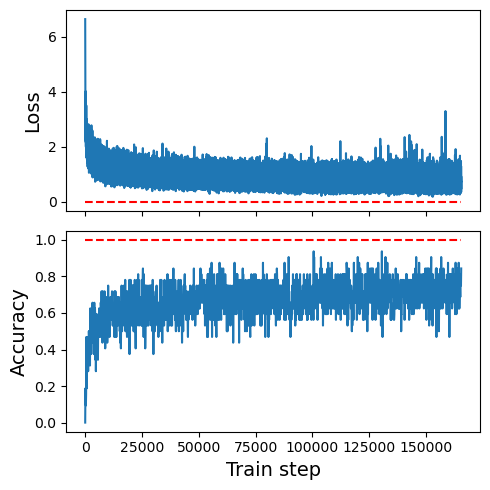

In [23]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

## Roll out on train data

In [24]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

In [26]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [27]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_12914/2933544183.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


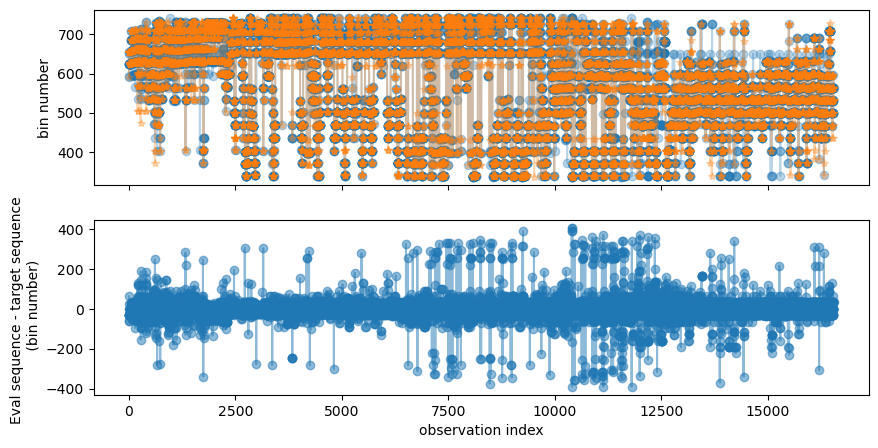

In [28]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence \n (bin number)')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

## Roll out on test data

In [44]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [45]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

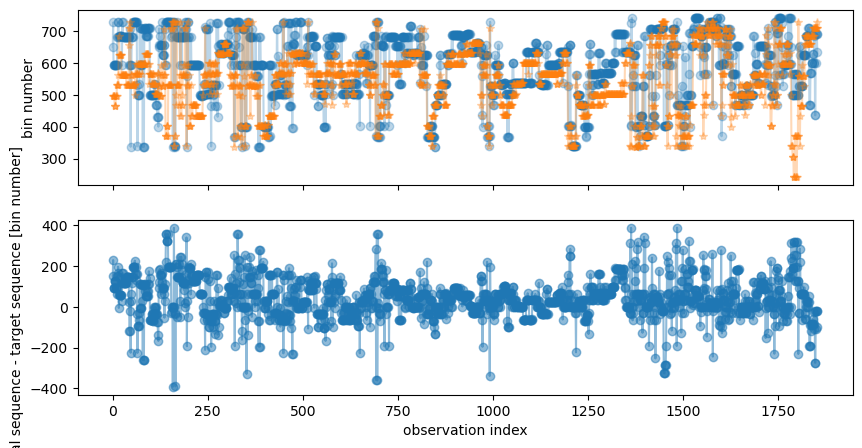

In [46]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')

In [47]:
import random

In [48]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_target_sequence])

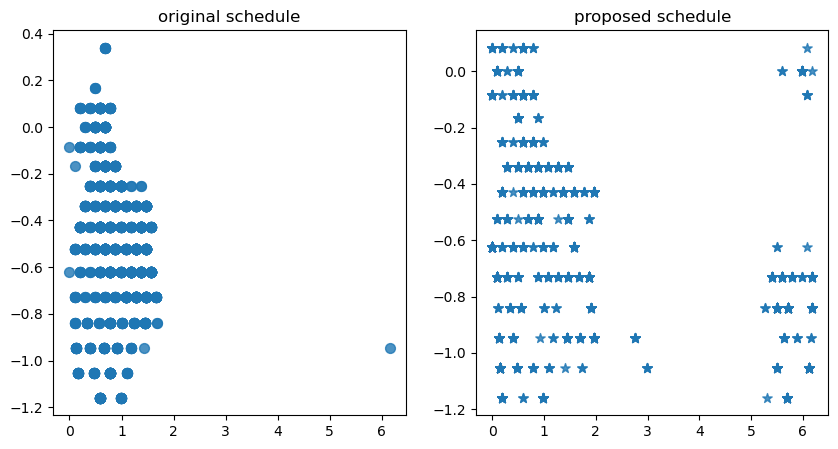

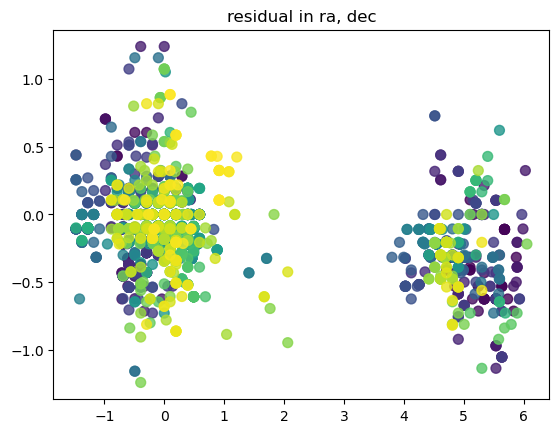

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], s=50, alpha=.8)
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], alpha=.8, s=50, marker='*')
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();


In [64]:
from survey_ops import plotting

In [35]:
import subprocess

In [77]:
def create_gif(outdir, dataset, policy_bin_ids, original_bin_ids, test_data=False, return_outputs=False):
    # def produce_schedule_for_video(outdir, id2radec):
    prefix = 'test_' if test_data else 'train_'
    field_filepath = outdir + prefix + 'fields2radec.json' # field id to ra_dec
    schedule_filepath = outdir + prefix + 'schedule.csv' # keys time and field_id

    timestamps = dataset._df['timestamp'].values.tolist()
    id2radec = {str(k): radec for k, radec in dataset.bin2radec.items()}
    
    # save field_to_radec
    with open(field_filepath, 'w') as f:
        json.dump(id2radec, f, indent=2)
    
    # save time, field_id, next_field_id
    data = {'time': timestamps, 'policy_bin_id': policy_bin_ids, 'bin_id': original_bin_ids}
    schedule_df = pd.DataFrame(data)
    schedule_df.to_csv(schedule_filepath, index=False)

    movie_outfile = 
    plotting.plot_fields_movie(
        outfile=outdir + '_' + prefix + 'movie.gif',
        times=schedule_df.time.values,
        ras=[id2radec[str(fid)][0] * units.deg for fid in schedule_df['bin_id'].values],
        decs=[id2radec[str(fid)][1] * units.deg for fid in schedule_df['bin_id'].values]
    )
    
    if return_outputs:
        return id2radec, schedule_df

In [78]:
id2radec, schedule_df = create_gif(outdir=fig_outdir, dataset=dataset, policy_bin_ids=eval_sequence, original_bin_ids=target_sequence, test_data=False, return_outputs=True)


In [79]:
schedule_df

,time,policy_bin_id,bin_id
0,1388624714,651,626
1,1388624897,655,655
2,1388625026,592,592
3,1388625148,655,655
4,1388625267,655,655
...,...,...,...
16542,1419999923,596,564
16543,1419999999,596,596
16544,1420000118,596,596
16545,1420000235,564,564


In [80]:
plotting.plot_fields_movie(
    outfile=outdir + 'test_data_movie.gif',
    times=schedule_df.time.values,
    ras=[id2radec[str(fid)][0] * units.deg for fid in schedule_df['bin_id'].values],
    decs=[id2radec[str(fid)][1] * units.deg for fid in schedule_df['bin_id'].values]
)

KeyboardInterrupt: 